## Face Generation

In [3]:
import helper
import problem_unittests as tests
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import tensorflow as tf

### CelebA Datasetの取得と表示

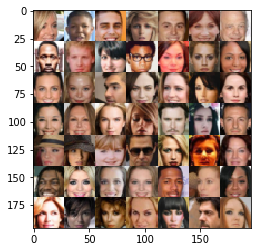

In [2]:
show_n_images = 50

celeb_images = helper.get_batch(glob(os.path.join('gan_celeba', './data/celebA/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeb_images, 'RGB'))

### Build the Neural  
  
#### 以下のようにDCGANのネットワークを構成します。  
  
  
#### ・model_inputs
#### ・discriminator
#### ・generator
#### ・model_loss
#### ・model_opt 
#### ・train

In [6]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """ model_inputs関数を実装して、ニューラルネットワークのTFプレースホルダを作成。
     ：param image_width：入力画像の幅
     ：param image_height：入力画像の高さ
     ：param image_channels：イメージチャンネルの数
     ：param z_dim：Zの次元
     ：戻り値：（実入力画像のテンソル、zデータのテンソル、学習率）のタプル
"""
    
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "input_real")
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), "input_z")
    learning_rate = tf.placeholder(tf.float32, name="lr")
    
    return real_inputs, z_inputs, learning_rate

tests.test_model_inputs(model_inputs)

Tests Passed


In [7]:
def discriminator(images, reuse=False):
    """"
     discriminatorを実装して、訓練画像かgeneratorが生成した画像かを識別するdiscriminatorニューラルネットワークを作成する。 この関数は、ニューラルネットワークの変数を再利用できる必要がある。 
        スコープ名が「discriminator」のtf.variable_scopeを使用すると、変数を再利用できる。 
     ：param image：入力画像のテンソル
     ：param reuse：ウェイトを再利用する必要がある場合はブール値
     ：return：タプル（discriminatorのテンソル出力、discriminatorのテンソルロジット）
     """
    alpha = 0.1
    keep_prob = 0.9
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        # 活性化関数として　Leaky Relu を使用。alphaを掛ける事で勾配が０にならない。
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        flat = tf.reshape(x3, (-1,  4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


tests.test_discriminator(discriminator, tf)

Tests Passed


In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
      ジェネレータネットワークを作成する
     ：パラメータz：入力z
     ：param out_channel_dim：出力イメージのチャネル数
     ：param is_train：ジェネレータがトレーニングに使用されている場合はブール値
     ：return：生成された28 x 28 x out_channel_dim画像
    """
    alpha = 0.1
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        # shape = 7x7x512
        
        # tf.layers.conv2d_transpose () ここでUpsampling　を行っている。
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=2, padding='same', activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        g2 = tf.nn.dropout(g2, keep_prob=keep_prob)
        # shape = 14x14x256
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same', activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)   
        g3 = tf.nn.dropout(g3, keep_prob=keep_prob)
        # shape = 28x28x128
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 3, strides=1, padding='same', activation=None)
        # shape = 28x28x5
        
        out = tf.tanh(logits)
        
        return out


tests.test_generator(generator, tf)

Tests Passed


In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    ディスクリミネータとジェネレータの損失を取得する
     ：param input_real：実際のデータセットからの画像
     ：param input_z：Z入力
     ：param out_channel_dim：出力イメージのチャネル数
     ：return：タプル（discriminator loss、generator loss）
    """
    smooth = 0.1
    g_output = generator(input_z, out_channel_dim)
    disc_output_real, disc_logits_real = discriminator(input_real)
    disc_output_fake, disc_logits_fake = discriminator(g_output, reuse=True)
    
    # 　discriminator が画像を本物と判断した損失値。
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_real,
            labels = tf.ones_like(disc_output_real) * (1 - smooth)
        )
    )
    # 画像がgeneratorが生成した偽の画像であると判断した損失値。
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.zeros_like(disc_output_fake)
        )
    )
    # generator　が 　discriminator　に本物だと判断させた損失値。
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.ones_like(disc_output_fake)
        )
    )
    
    disc_loss = disc_loss_real + disc_loss_fake
    return disc_loss, gen_loss


tests.test_model_loss(model_loss)

Tests Passed


In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    最適化操作を取得する
     ：param d_loss：ディスクリミネータ損失Tensor
     ：パラメータg_loss：ジェネレータ損失Tensor
     ：param learning_rate：学習率プレースホルダ
     ：param beta1：オプティマイザの第1瞬間の指数関数的減衰率
     ：return：タプル（discriminator training operation、generator training operation）
    """
  
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    # tf.get_collection()  Graph.get_collection()デフォルトグラフを使用するためのラッパー。 
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    # Graph.control_dependencies()デフォルトグラフを使用するためのラッパー。
    # Args - control_inputs：コンテキストで定義された操作を実行する前に実行または計算されなければならないリスト
    # generator　と discriminator の loss を最適化する。
    with tf.control_dependencies(update_ops):
        gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)

        return disc_train_opt, gen_train_opt



tests.test_model_opt(model_opt, tf)

Tests Passed


In [11]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
      ジェネレータの出力例を表示する
     ：param sess：TensorFlowセッション
     ：param n_images：表示する画像の数
     ：param input_z：入力Z Tensor
     ：param out_channel_dim：出力イメージのチャネル数
     ：param image_mode：イメージ（ "RGB"または "L"）に使用するモード
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
     GANを訓練する
     ：param epoch_count：エポックの数
     ：param batch_size：バッチサイズ
     ：param z_dim：Z次元
     ：param learning_rate：学習率
     ：param beta1：オプティマイザの第1瞬間の指数関数的減衰率
     ：param get_batches：バッチを取得する関数
     ：param data_shape：データの形状
     ：param data_image_mode：イメージ（ "RGB"または "L"）に使用するイメージモード
    """
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)

    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    total_steps = epoch_count * batch_size

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    disc_opt, 
                    feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate 
                    }
                )
                _ = sess.run(
                    gen_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z, 
                        lr:learning_rate
                    }
                )
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    # ＃各エポックの終わりに、損失を得てそれらをプリントアウトする
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                            "Generator Loss: {:.4f}".format(train_loss_g),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d))
                    # 訓練後の損失を保存する
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    

        saver.save(sess, './generator.ckpt')
                
    return losses

### Execution　

initial output:


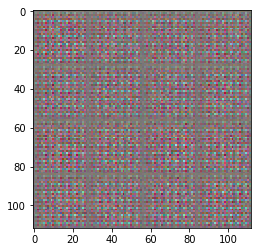

Epoch 1/1... Generator Loss: 3.7014 Discriminator Loss: 0.4284...
Epoch 1/1... Generator Loss: 5.7433 Discriminator Loss: 0.4007...
Epoch 1/1... Generator Loss: 4.0970 Discriminator Loss: 0.4937...
Epoch 1/1... Generator Loss: 1.8376 Discriminator Loss: 0.6889...
Epoch 1/1... Generator Loss: 3.4052 Discriminator Loss: 1.0070...
Epoch 1/1... Generator Loss: 0.7880 Discriminator Loss: 1.1702...
Epoch 1/1... Generator Loss: 2.3064 Discriminator Loss: 0.5443...
Epoch 1/1... Generator Loss: 2.1533 Discriminator Loss: 0.5326...
Epoch 1/1... Generator Loss: 1.9243 Discriminator Loss: 0.6049...


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join('gan_celeba','./data/celebA/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)